# E-commerce Product Descriptions Classification

# Data Description

The dataset was taken from: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

This is the classification based E-commerce text dataset for 4 categories - "Electronics", "Household", "Books" and "Clothing & Accessories", which almost cover 80% of any E-commerce website.

The dataset is in ".csv" format with two columns - the first column is the class name and the second one is the datapoint of that class. The data point is the product and description from the e-commerce website.

# Importing necessary libraries & loading data

In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.6 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 71.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel
from transformers import BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm, trange

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d saurabhshahane/ecommerce-text-classification

 89% 7.00M/7.86M [00:00<00:00, 72.8MB/s]
100% 7.86M/7.86M [00:00<00:00, 80.0MB/s]


In [8]:
%%capture
! unzip ecommerce-text-classification.zip

In [9]:
df = pd.read_csv('/content/ecommerceDataset.csv', header=None)
df = df.rename(columns={0: 'Category', 1: 'Description'})
df.head()

,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


# Data Preprocessing

In [10]:
df.isna().sum()

Category       0
Description    1
dtype: int64

In [11]:
# dropping missing values
df.dropna(inplace=True)

In [12]:
# dropping duplicates
df.drop_duplicates(inplace=True)

In [13]:
df.index = [i for i in range(len(df))]

In [14]:
class_dist = df.groupby(by='Category', as_index=False).count()
class_dist.sort_values(by='Description', inplace=True, ascending=False)
class_dist.rename(columns={'Description': 'Quantity'}, inplace=True)
class_dist

,Category,Quantity
3,Household,10564
0,Books,6256
1,Clothing & Accessories,5674
2,Electronics,5308


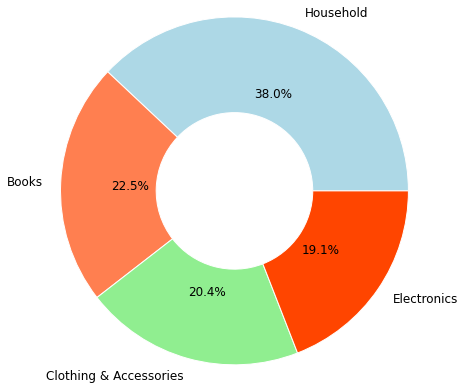

In [16]:
# visualizing class distribution
counts = class_dist['Quantity']
labels = class_dist['Category']

pie_plot, _, _ = plt.pie(counts,
                         radius=2.0,
                         labels=labels,
                         colors = ['lightblue', 'coral', 'lightgreen','orangered'],
                         autopct='%.1f%%',
                         textprops = {'fontsize': 12})
plt.setp(pie_plot, width=1.1, edgecolor='white')
plt.show()

In [17]:
# splitting the dataset into train, validation and test parts
seed = 42
np.random.seed(seed)
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=seed),
                            [int(0.7 * len(df)), int(0.9 * len(df))])

print('Splitted the dataset into 3 parts: {} train samples, {} validation samples, {} test samples'.format(
    len(train_df), len(val_df), len(test_df)))

Splitted the dataset into 3 parts: 19461 train samples, 5560 validation samples, 2781 test samples


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Household': 0,
          'Books': 1,
          'Clothing & Accessories': 2,
          'Electronics': 3}

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
class Ecommerce_Dataset(Dataset):
  def __init__(self, df):
    self.labels = [labels[label] for label in df['Category']]
    self.descriptions = [tokenizer(desc, padding='max_length', max_length = 64, truncation=True, return_tensors='pt') for desc in df['Description']]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    batch_texts = self.descriptions[index]
    batch_labels = np.array(self.labels[index])
    return batch_texts, batch_labels

In [22]:
train_dataset = Ecommerce_Dataset(train_df)
val_dataset = Ecommerce_Dataset(val_df)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [27]:
# checking if dataloader works correctly
batch_texts, batch_labels = next(iter(train_loader))

# Model Training

In [30]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=0.3):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 4)
    self.relu = nn.ReLU()

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    result = self.relu(linear_output)
    return result

In [31]:
model = BertClassifier()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def train_network(model, optimizer, criterion, n_epochs):
  progress_bar = trange(n_epochs, desc='Epoch:')
  for epoch in progress_bar:
    train_accuracy = 0
    train_loss = 0

    for train_input, train_label in tqdm(train_loader, leave=False, desc=f'Train iter:'):
      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)
      output = model(input_id, mask)
                
      batch_loss = criterion(output, train_label)
      train_loss += batch_loss.item()
                
      batch_accuracy = (output.argmax(dim=1) == train_label).sum().item()
      train_accuracy += batch_accuracy

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
            
    val_accuracy = 0
    val_loss = 0

    with torch.no_grad():
      for val_input, val_label in tqdm(val_loader, leave=False, desc=f'Val iter:'):
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label)
        val_loss += batch_loss.item()
                    
        batch_accuracy = (output.argmax(dim=1) == val_label).sum().item()
        val_accuracy += batch_accuracy
            
    print(f'Epoch: {epoch} | Train Loss: {train_loss / len(train_df): .3f} \
          Train Accuracy: {train_accuracy / len(train_df): .3f} \
          Val Loss: {val_loss / len(val_df): .3f} \
          Val Accuracy: {val_accuracy / len(val_df): .3f}')

In [33]:
train_network(model, optimizer, criterion, 4)

Epoch::   0%|          | 0/4 [00:00<?, ?it/s]

Train iter::   0%|          | 0/1217 [00:00<?, ?it/s]

Val iter::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 0 | Train Loss:  0.017           Train Accuracy:  0.920           Val Loss:  0.012           Val Accuracy:  0.949


Train iter::   0%|          | 0/1217 [00:00<?, ?it/s]

Val iter::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.007           Train Accuracy:  0.969           Val Loss:  0.011           Val Accuracy:  0.953


Train iter::   0%|          | 0/1217 [00:00<?, ?it/s]

Val iter::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.004           Train Accuracy:  0.982           Val Loss:  0.011           Val Accuracy:  0.955


Train iter::   0%|          | 0/1217 [00:00<?, ?it/s]

Val iter::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.003           Train Accuracy:  0.990           Val Loss:  0.012           Val Accuracy:  0.955


In [34]:
torch.save(model.state_dict(), 'bert_ecom')

# Inference

In [35]:
test_dataset = Ecommerce_Dataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [36]:
def evaluate_network(model, test_df):
  test_accuracy = 0
  with torch.no_grad():
    for test_input, test_label in tqdm(test_loader, leave=False):
      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)
      output = model(input_id, mask)
      batch_accuracy = (output.argmax(dim=1) == test_label).sum().item()
      test_accuracy += batch_accuracy
    
  print(f'Test Accuracy: {test_accuracy / len(test_df): .3f}')

In [37]:
evaluate_network(model, test_df)

  0%|          | 0/174 [00:00<?, ?it/s]

Test Accuracy:  0.954
